# Introduction to Text Classification

-----

In this notebook, we introduce text classification. This is a powerful, yet sometimes intimidating topic that finds applications in a number of different areas: product reviews, sentiment analysis, and document classification. Part of the challenge lies in the difficulty of applying mathematical algorithms to (potentially very large) character data sets. In Python, however, this challenge is considerably simplified by using the NLTK and the scikit learn machine learning libraries.

-----

## Table of Contents

[Data](#Data)

[Classification](#Parsing-Data)

- [Naive Bayes Classifier](#Naive-Bayes-Classifier)

[Stop Words](#Stop-Words)

- [Stop Words & Classification](#Stop-Words-&-Classification)

[TF-IDF](#TF-IDF)

[Document Classification](#Document-Classification)

- [Linear SVC](#Linear SVC)
- [SVC with SGD](#SVC-with-SGD)
- [Logistic Regression](#Logistic-Regression)

[Sentiment Analysis](#Sentiment-Analysis)

-----

Before proceeding with the rest of this notebook, we first include our standard notebook setup code and we define our _data_ directory.

-----

In [1]:
# Set up notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# First we find our HOME directory
home_dir = !echo $HOME

# Then we create a temporary working directory to store data files in
!mkdir ~/temp_w9l2

# We construct the full path, below our   
# HOME directory to the temporary working directory location
home=home_dir[0] + '/temp_w9l2/'

-----

[[Back to TOC]](#Table-of-Contents)


## Data

To get started with text classification, we will analyze the [twenty newsgroup][tng] data set. We first download this data (scikit learn has built in methods for doing this, however, we have cached a copy locally on our server). The data are made available via a custom object, but we can access the data of interest by using dictionary keys. Before delving into text data mining, we first explore this data over several Code cells to understand more about the task at hand.

-----

[tng]: http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html

In [3]:
# load dataset
from sklearn.datasets import fetch_20newsgroups

# Split into training and testing
train = fetch_20newsgroups(data_home=home + 'textdm', 
                           subset='train', shuffle=True, random_state=23)
test = fetch_20newsgroups(data_home=home + 'textdm', 
                          subset='test', shuffle=True, random_state=23)

In [4]:
# Exploratory Data Analysis
print(f"Number of Training Samples: {len(train['data'])}")
print(f"Number of Testing Samples: {len(test['data'])}")
print(40*'-')

for idx, label in enumerate(train['target_names']):
    print(f'Class {idx:2d} = {label}')

Number of Training Samples: 11314
Number of Testing Samples: 7532
----------------------------------------
Class  0 = alt.atheism
Class  1 = comp.graphics
Class  2 = comp.os.ms-windows.misc
Class  3 = comp.sys.ibm.pc.hardware
Class  4 = comp.sys.mac.hardware
Class  5 = comp.windows.x
Class  6 = misc.forsale
Class  7 = rec.autos
Class  8 = rec.motorcycles
Class  9 = rec.sport.baseball
Class 10 = rec.sport.hockey
Class 11 = sci.crypt
Class 12 = sci.electronics
Class 13 = sci.med
Class 14 = sci.space
Class 15 = soc.religion.christian
Class 16 = talk.politics.guns
Class 17 = talk.politics.mideast
Class 18 = talk.politics.misc
Class 19 = talk.religion.misc


In [5]:
# Pick a single article and display information
item_number = 250
class_num = train['target'][item_number]
print(f'Class Number = {class_num}')
print(f'Class Name = {train["target_names"][class_num]}')
print("-"*80)
print(train['data'][item_number])

Class Number = 8
Class Name = rec.motorcycles
--------------------------------------------------------------------------------
From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
pr

-----

[[Back to TOC]](#Table-of-Contents)

## Classification

In the _Introduction to Text Analysis_ notebook, we identified the features (or tokens in the training documents) that we should use to classify our documents. But this potential obscures the challenge of actually classifying documents. Before introducing our first classification technique, lets examine one document that is in our test data set. 

Reviewing this single posting, we notice several issues that might affect our classification process. First, if we remove the header, footer, and quoted text, some message will have little to no signal. For example, the message below would simply contain 'Calling Bill Gates, calling Bill Gates....'. Second, if we don't remove this information, our documents will include email address information (like com, edu, etc.), proper names, and information such as dates or monetary information. Finally, the content in some categories will clearly overlap, such as _alt.atheism_ and _soc.religion.christian_. 

In the end, these issues demonstrate the **remaining need** for manual intervention and introspection during the machine learning process. We will continually want to analyze classification results to ensure we understand what is occurring and why it is occurring.

-----
[l1]: intro2ta.ipynb

In [6]:
test_message = 100
class_num = test['target'][test_message]
print(f'Class Number = {class_num}')
print(f'Class Name = {test["target_names"][class_num]}')
print("-"*80)
print(test['data'][test_message])

Class Number = 1
Class Name = comp.graphics
--------------------------------------------------------------------------------
From: ecampbel@metz.une.edu.au (Ed Campbell)
Subject: libraries for text+math+graphics display?
Keywords: text+math fonts display c-code
Lines: 8
Nntp-Posting-Host: metz.une.edu.au

Does anyone know of any c or c++ libraries for preparing
and displaying quickly pages of mixed text, mathematical equations,
and graphics (circles,ellipses,etc) on the vdu? The maths wouldnt
need to be up to TeX quality, but it would be useful to be scaleable.
The main thing would be to be able to generate the display quickly
from a minimum set of formatting code.
Thanks,
Ed Campbell



-----

[[Back to TOC]](#Table-of-Contents)

### Naive Bayes Classifier

One of the (if not the) simplest techniques for performing text classification is the [Naive Bayes classifier][nbd]. This technique is popular, in part because of its simplicity, yet it also provides a quick technique that can provide reasonable results. Fundamentally this method applies Bayes theorem by (naively) assuming independence between the features. In scikit learn, we will use a [Multinomial Naive Bayes][nbapi] model, where we treat each feature independently. Thus we calculate the likelihood of a feature corresponding to each training label, and the accumulation of these likelihoods provides our overall classification. By working with log-likelihoods, this accumulation becomes a simple sum.

-----

[nbd]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
[nbapi]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [7]:
# Classify text with Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Create DTM
cv = CountVectorizer()
train_counts = cv.fit_transform(train['data'])
test_data = cv.transform(test['data'])

# Create Classifier
nb = MultinomialNB()
clf = nb.fit(train_counts, train['target'])

# Predict and display score
predicted = clf.predict(test_data)
scr = 100.0 * clf.score(test_data, test['target'])
print(f'NB prediction accuracy = {scr:5.1f}%')

NB prediction accuracy =  77.3%


In [8]:
# Implement as a pipeline
from sklearn.pipeline import Pipeline

tools = [('cv', CountVectorizer()), 
         ('nb', MultinomialNB())]

# Construct pipeline
clf = Pipeline(tools)
clf = clf.fit(train['data'], train['target'])

# Predict and display scores
predicted = clf.predict(test['data'])
scr = 100.0 * clf.score(test['data'], test['target'])
print(f'NB prediction accuracy = {scr:5.1f}%')

NB prediction accuracy =  77.3%


-----

We can also use the built-in `metrics` methods to display more information about the classification results, including as a function of the different labels. Notice how most labels are predicted well, or at least close to the average. But some, such as _comp.os.ms-windows.misc_, are predicted poorly, suggesting improvements will be needed.

-----

In [9]:
from sklearn import metrics
print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.77      0.78       319
           comp.graphics       0.67      0.74      0.70       389
 comp.os.ms-windows.misc       0.20      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.56      0.77      0.65       392
   comp.sys.mac.hardware       0.84      0.75      0.79       385
          comp.windows.x       0.65      0.84      0.73       395
            misc.forsale       0.93      0.65      0.77       390
               rec.autos       0.87      0.91      0.89       396
         rec.motorcycles       0.96      0.92      0.94       398
      rec.sport.baseball       0.96      0.87      0.91       397
        rec.sport.hockey       0.93      0.96      0.95       399
               sci.crypt       0.67      0.95      0.78       396
         sci.electronics       0.79      0.66      0.72       393
                 sci.med       0.87      0.82      0.85       396
         

-----

We can also visually display the confusion matrix (where we show how documents were misclassified) by using Seaborn to create a _heatmap_ visual. First, we create our confusion matrix method, which we subsequently use to display the results from our Naive Bayes model.

-----

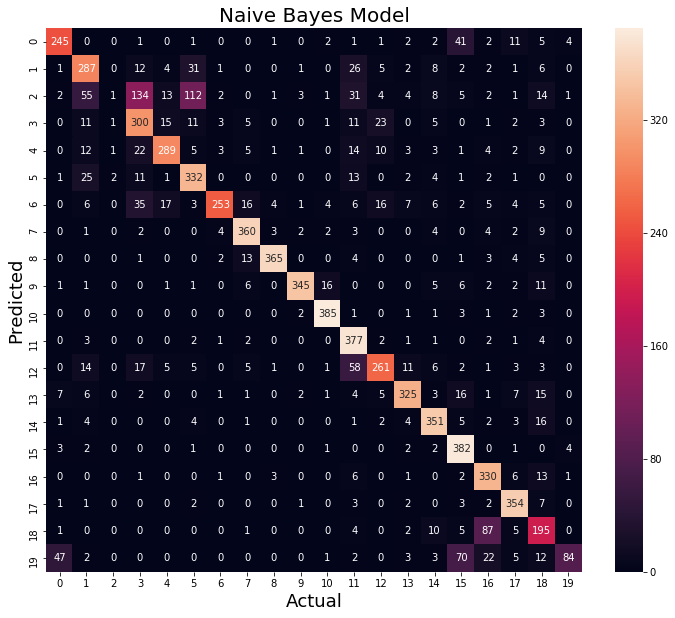

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

# Display confusion matrix
from helper_code import mlplots as mp
mp.confusion(test['target'], predicted, 
             range(20), 20, 'Naive Bayes Model')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used `CountVectorizer` to create a document term matrix, and a Naive Bayes algorithm to classify new document by using this DTM. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the `CountVectorizer` so that all words are changed to lowercase. Does this change the classification results?
2. Change the `CountVectorizer` so that all accents are removed from words. Does this change the classification results?
3. Change the smoothing parameter $\alpha$ for the `MultinomialNB` classifier, from the default of one to zero and next some fractional value between zero and one. How does this change the classification results?

-----

[[Back to TOC]](#Table-of-Contents)


## Stop Words

Text documents often contain many occurrences of the same word. For example, in a document written in _English_, words such as _a_, _the_, _of_, and _it_ likely occur very frequently. When classifying a document based on the number of times specific words occur in the text document, these words can lead to biases, especially since they are generally common in **all** text documents you might want to classify. As a result, the concept of [_stop words_][swd] was invented. Basically these words are the most commonly occurring words that should be removed during the tokenization process in order to improve subsequent classification efforts. 

We can easily specify that the __English__ stop words should be excluded during tokenization by using the `stop_words`. Note, _stop word_ dictionaries for other languages, or even specific domains, exist and can be used instead. We demonstrate the removal of stop words by using a `CountVectorizer` in the following simple example.

-----
[swd]: https://en.wikipedia.org/wiki/Stop_words

In [11]:
# Sample sentance to tokenize
my_text = 'This course introduces many concepts in data science.'

# Create tokenizers
cv1 = CountVectorizer(lowercase=True)
cv2 = CountVectorizer(stop_words = 'english', lowercase=True)

# Apply tokenizers
tk_func1 = cv1.build_analyzer()
tk_func2 = cv2.build_analyzer()

# Display tokenization results
import pprint
pp = pprint.PrettyPrinter(indent=2, depth=1, 
                          width=80, compact=True)

print('Tokenization:')
pp.pprint(tk_func1(my_text))

# Blank line
print()

print('Tokenization (with Stop words):')
pp.pprint(tk_func2(my_text))

Tokenization:
['this', 'course', 'introduces', 'many', 'concepts', 'in', 'data', 'science']

Tokenization (with Stop words):
['course', 'introduces', 'concepts', 'data', 'science']


-----

[[Back to TOC]](#Table-of-Contents)

### Stop Words & Classification

Since _stop words_ are generally common across text documents, their presence in a classification process likely to simply increase the noise. As a result, by removing stop words, we likely will produce more accurate classification. In the following Code cell, we demonstrate the removal of stop words in our classification pipeline, which, even with this simple approach, increases the accuracy of our classification results.

-----

In [12]:
# Modify parameters in out Pipeline and rerun.
# In this case, we set stop words 
clf.set_params(cv__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

scr = 100.0 * clf.score(test['data'], test['target'])
print(f'NB (with Stop Words) prediction accuracy = {scr:5.1f}%')

NB (with Stop Words) prediction accuracy =  80.2%


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used stop words to remove common tokens from a text document. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Create your own sentence, instead of the text associated with `my_text`. Do the token results make sense with an without stop words being used?
2. Using stop words, also change tokens to lowercase in the pipeline. Does this change the classification results?
3. You can supply your own list of stop words, simply pass in a list of string tokens (e.g., `['in', 'many']`). Try doing this with a sentence of your own construction. Did the tokenization results agree with your expectation

-----

[[Back to TOC]](#Table-of-Contents)


## TF-IDF

Previously, we have simply used the number of times a token (i.e., word, or more generally an n-gram) occurs in a document to classify the document. Even with the removal of stop words, however, this can still overemphasize tokens that might generally occur across many documents (e.g., names or general concepts). An alternative technique that often provides robust improvements in classification accuracy is to employ the frequency of token occurrence, normalized over the frequency with which the token occurs in all documents. In this manner, we give higher weight in the classification process to tokens that are more strongly tied to a particular label. 

Formally this concept is known as [term frequency–inverse document frequency][tfd] (or tf-idf), and scikit-learn provides this functionality via the [`TfidfTransformer`][tftd] that can either follow a tokenizer, such as `CountVectorizer` or can be combined together into a single transformer via the [`TfidfVectorizer`][tfvd].

-----
[tfd]: https://en.wikipedia.org/wiki/Tf–idf

[tftd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

[tfvd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tools = [('tf', TfidfVectorizer()), ('nb', MultinomialNB())]
clf = Pipeline(tools)
clf.set_params(tf__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

scr = 100.0 * clf.score(test['data'], test['target'])
print(f'NB (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

NB (TF-IDF with Stop Words) prediction accuracy =  81.7%


-----

[[Back to TOC]](#Table-of-Contents)


## Document Classification

We now look at more advanced classification techniques than the Naive Bayes classification technique that we employed previously in this notebook.

### Linear SVC

One of the simplest classification techniques to understand is [support vector machine][svmd] classification, or SVC. SVC attempts to divide data by finding (hyper-)planes that optimally differentiate data between classes. For our text data mining, we can employ linear SVM for classification, known as linear SVC, to classify text documents by their token feature vectors. The scikit_learn library implements this technique in the [`LinearSVC`][lsvc] class. Notice how the output classes are predicted more consistently than our first classification attempt (i.e., the metrics are consistent across classes).

-----
[lsvc]: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
[svmd]: https://en.wikipedia.org/wiki/Support_vector_machine

In [14]:
from sklearn import svm

tools = [('tf', TfidfVectorizer()), ('svc', svm.LinearSVC())]
clf = Pipeline(tools)

clf.set_params(tf__stop_words = 'english')
clf.set_params(svc__C = 1000)

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

scr = 100.0 * clf.score(test['data'], test['target'])
print(f'SVC (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

SVC (TF-IDF with Stop Words) prediction accuracy =  83.3%


In [15]:
from sklearn import metrics

print(metrics.classification_report(test['target'], 
                                    predicted,
                                    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.85      0.76      0.80       319
           comp.graphics       0.76      0.78      0.77       389
 comp.os.ms-windows.misc       0.72      0.69      0.71       394
comp.sys.ibm.pc.hardware       0.65      0.72      0.68       392
   comp.sys.mac.hardware       0.80      0.82      0.81       385
          comp.windows.x       0.83      0.74      0.79       395
            misc.forsale       0.73      0.84      0.79       390
               rec.autos       0.90      0.88      0.89       396
         rec.motorcycles       0.94      0.95      0.95       398
      rec.sport.baseball       0.90      0.93      0.92       397
        rec.sport.hockey       0.96      0.97      0.97       399
               sci.crypt       0.93      0.93      0.93       396
         sci.electronics       0.75      0.74      0.75       393
                 sci.med       0.91      0.85      0.88       396
         

-----

[[Back to TOC]](#Table-of-Contents)


### SVC with SGD

We can use a [modified linear SVC][sgd] classifier that employs stochastic gradient descent to quantify the loss for each sample, which is used to update the classification model. Note for best results, we want our data to have zero mean and unit variance for this technique to optimally work. Since our text data do not have this, we should expect suboptimal results (or else try to normalize the data appropriately).

-----
[sgd]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [16]:
from sklearn.linear_model import SGDClassifier

tools = [('tf', TfidfVectorizer()), ('sgd', SGDClassifier())]
clf = Pipeline(tools)

clf.set_params(tf__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

scr = 100.0 * clf.score(test['data'], test['target'])
print(f'SGD (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

SGD (TF-IDF with Stop Words) prediction accuracy =  85.1%


-----

[[Back to TOC]](#Table-of-Contents)

### Logistic Regression

[Logistic Regression][lrd] is typically employed on categorical variables, such as yes/no decision, or win/loss likelihoods. In the case of many labels, we can use the trick that logistic regression can quantify the likelihood a vector is in or out of a particular category. Thus, by computing this over all categories we can determine the best label for each test vector. [scikit_learn][sllr] provides an implementation that can be easily used for our classification problem.

-----

[lrd]: https://en.wikipedia.org/wiki/Logistic_regression
[sllr]: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                ('tfidf', TfidfTransformer()),
                ('lr', LogisticRegression(C=1000))])


clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

scr = 100.0 * clf.score(test['data'], test['target'])
print(f'LR (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

LR (TF-IDF with Stop Words) prediction accuracy =  84.9%


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we introduced TF-IDF and demonstrated other, more powerful classification algorithms to this text classification problem. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Try changing the following parameters to `CountVectorizer` or `TfidfVectorizer`: `lowercase`, `max_features`, `min_df` and `max_df`, and `norm`. How do these attributes affect the performance of the classification?

2. When using `LogisticRegression`, we did not employ any regularization. Add a penalty term, `penalty='l1'` or `penalty='l2'` and run the classification pipeline. How does this change the results? How does this change the features identified by the algorithm?

3. Add a grid search to the pipeline for one particular classification algorithm, for example, `SGDClassifier` to find the optimal set of parameter to achieve the highest accuracy.

-----

[[Back to TOC]](#Table-of-Contents)


## Sentiment Analysis

We now turn to classification problem where the goal is to classify based on sentiment, negative or positive. We will approach this as a simple classification problem (note, one can do more sophisticated sentiment analysis based on the presence or absence of specific words). We first load our data. In this case, however, we employ the scikit learn data loading functionality to build training and testing data.

-----

In [18]:
import nltk
mvr = nltk.corpus.movie_reviews

from sklearn.datasets import load_files

data_dir = '/home/data_scientist/data/nltk_data/corpora/movie_reviews'
mvr = load_files(data_dir, shuffle = False)
print(f'Number of Reviews: {len(mvr.data)}')

Number of Reviews: 2000


In [19]:
from sklearn.model_selection import train_test_split

mvr_train, mvr_test, y_train, y_test = train_test_split(
    mvr.data, mvr.target, test_size=0.25, random_state=23)

-----

Now that the training and testing data have been loaded into the notebook, we can build a simple pipeline by using a `CountVectorizer` and `MultinomialNB` to build a document-term matrix and to perform a Naive Bayes classification. With this simple approach, we easily obtain reasonable results (over 80% accuracy). In the second Code cell, we display the top terms for each category.

-----

In [20]:
# Build simple pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# Build DTM and classify data
pipeline.fit(mvr_train, y_train)
y_pred = pipeline.predict(mvr_test)
print(metrics.classification_report(y_test, y_pred, 
                                    target_names = mvr.target_names))

             precision    recall  f1-score   support

        neg       0.82      0.81      0.81       259
        pos       0.80      0.80      0.80       241

avg / total       0.81      0.81      0.81       500



In [21]:
# Display top terms per catgory.

top_count = 20
import numpy as np

# Extract pipeline steps.
nb = pipeline.steps[1][1]
cv = pipeline.steps[0][1]
features = cv.get_feature_names()

print('Label: Features')
print(75*'-')
for idx, target in enumerate(mvr.target_names):
    top_targets = np.argsort(nb.feature_log_prob_[idx])[-top_count:]
    top_features = " ".join(features[jdx] for jdx in top_targets)
    print(f'{target:5s}: {top_features}')

Label: Features
---------------------------------------------------------------------------
neg  : be are movie on he his but film for this as with that it in is of to and the
pos  : one by are on but this he for film his with as that it in is to of and the


In [22]:
#Clean up - removing the temporary directory we created at the beginning of the lesson
!rm -rf $HOME/temp_w9l2

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used a simple pipeline to perform sentiment analysis. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Use stop words in the `CountVectorizer`. How do the results, including the top terms, change?
2. Change the vectorizer to TF-IDF. How do the results change (in particular the top terms)?
3. Change the other TF-IDF parameters, such as `max_features` and `lowercase`. How do the results change (including the top terms)?
4. Change the classifier to a more powerful algorithm. How do the results change (in particular the top terms)?

Can you explain (feel free to use the class forums) why the classification algorithm performed in the  manner it did ?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Overview of text mining in the [digital humanities][tudh]
1. Wikipedia articles on [Text Mining][wtm] and [Stop Words][wsw]
1. Gentle Introduction (in Python 2) to text analysis with Python, [part 3][nctap3]
1. Blog on computing TF-IDF, [Part 1][btf1] and [Part II][btf2]
1. Blog on Sentiment Analysis with NLTK, [Part 1][bsa1] and [Part II][bsa2]
1. [Text classification][sktc] using scikit learn
1. scikit learn documentation on [Text Feature Extraction][sktfe], sections 4.2.3.1 through 4.2.3.5
1. Computing [Term Frequencies][ctf] in Python
1. Sections 3, 4, and 5 from Chapter 6 of the free [NLTK version 3.0][nltk3-6] book

-----

[tudh]: http://tedunderwood.com/2015/06/04/seven-ways-humanists-are-using-computers-to-understand-text/
[wtm]: https://en.wikipedia.org/wiki/Text_mining
[wsw]: https://en.wikipedia.org/wiki/Stop_words


[sktc]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
[sktfe]: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

[btf1]: http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/
[btf2]: http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/

[bsa1]: http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/
[bsa2]: http://streamhacker.com/2010/05/17/text-classification-sentiment-analysis-precision-recall/

[ctf]: http://marcobonzanini.com/2015/03/17/mining-twitter-data-with-python-part-3-term-frequencies/


[nctap3]: http://nealcaren.web.unc.edu/an-introduction-to-text-analysis-with-python-part-3/
[nltk3-6]: http://www.nltk.org/book/ch06.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode